# Plot matched MA and LN adaptive responses to block vs natural song segments

Our prediction is: for the class of LN models we consider (double-exponential filters within a range of timescales + rectifying nonlinearity), the equivalent MA models can show a stronger response to natural song, but LN models cannot.

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from aux import zscore, get_seg
from disp import set_plot, plot_b, get_line

from record import smlt_ppln_ma, smlt_ppln_lnrelu

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

In [2]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Natural song snippets

In [3]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [4]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [5]:
from aux import get_seg
# get snippets
nt = int(round(60*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sng_s_long= 1*np.ones(len(t))
sng_p_long= 2*np.ones(len(t))

sng_s = np.zeros(len(t))

sng_s[t < 10] = 1
sng_s[(20 <= t) & (t < 30)] = 1
sng_s[(40 <= t) & (t < 50)] = 1

sng_p = np.zeros(len(t))

sng_p[t < 10] = 2
sng_p[(20 <= t) & (t < 30)] = 2
sng_p[(40 <= t) & (t < 50)] = 2

sngs_all = [sng_s_long, sng_p_long, sng_s, sng_p]  # song snippets


for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs_all.extend(segs)
    
sngs_all = np.array(sngs_all)

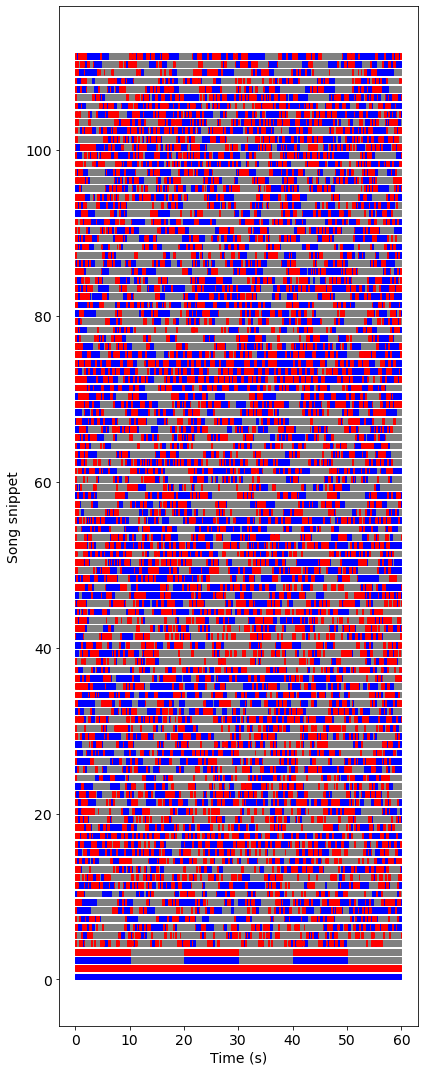

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs_all[:400]):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])
    
set_plot(ax, x_label='Time (s)', y_label='Song snippet', font_size=14)

### Simulate responses of matched MA/LN neuron pairs to different song segments

In [7]:
def ma_to_h_ln(tau_r, tau_a, x_s, x_p, dt):
    """Given a set of MA params, get LN filters that match MA step response."""
    th = np.arange(0, np.min([5*np.max([tau_r, tau_a]), 800]), dt)  # filter time vec
    gam = (1/tau_a) - (1/tau_r)
    
    if np.abs(gam) > 1e-8:
        r_step_s = x_s/(gam*tau_r) * np.exp(-th/tau_a) * (np.exp(gam*th) - 1)
        r_step_p = x_p/(gam*tau_r) * np.exp(-th/tau_a) * (np.exp(gam*th) - 1)
    else:
        r_step_s = x_s/tau_r * np.exp(-th/tau_a) * th
        r_step_p = x_p/tau_r * np.exp(-th/tau_a) * th
        
    h_s = np.gradient(r_step_s, dt)
    h_p = np.gradient(r_step_p, dt)
    
    return h_s, h_p, th

In [8]:
isngs = [0, 1, 16]
nsng = 3

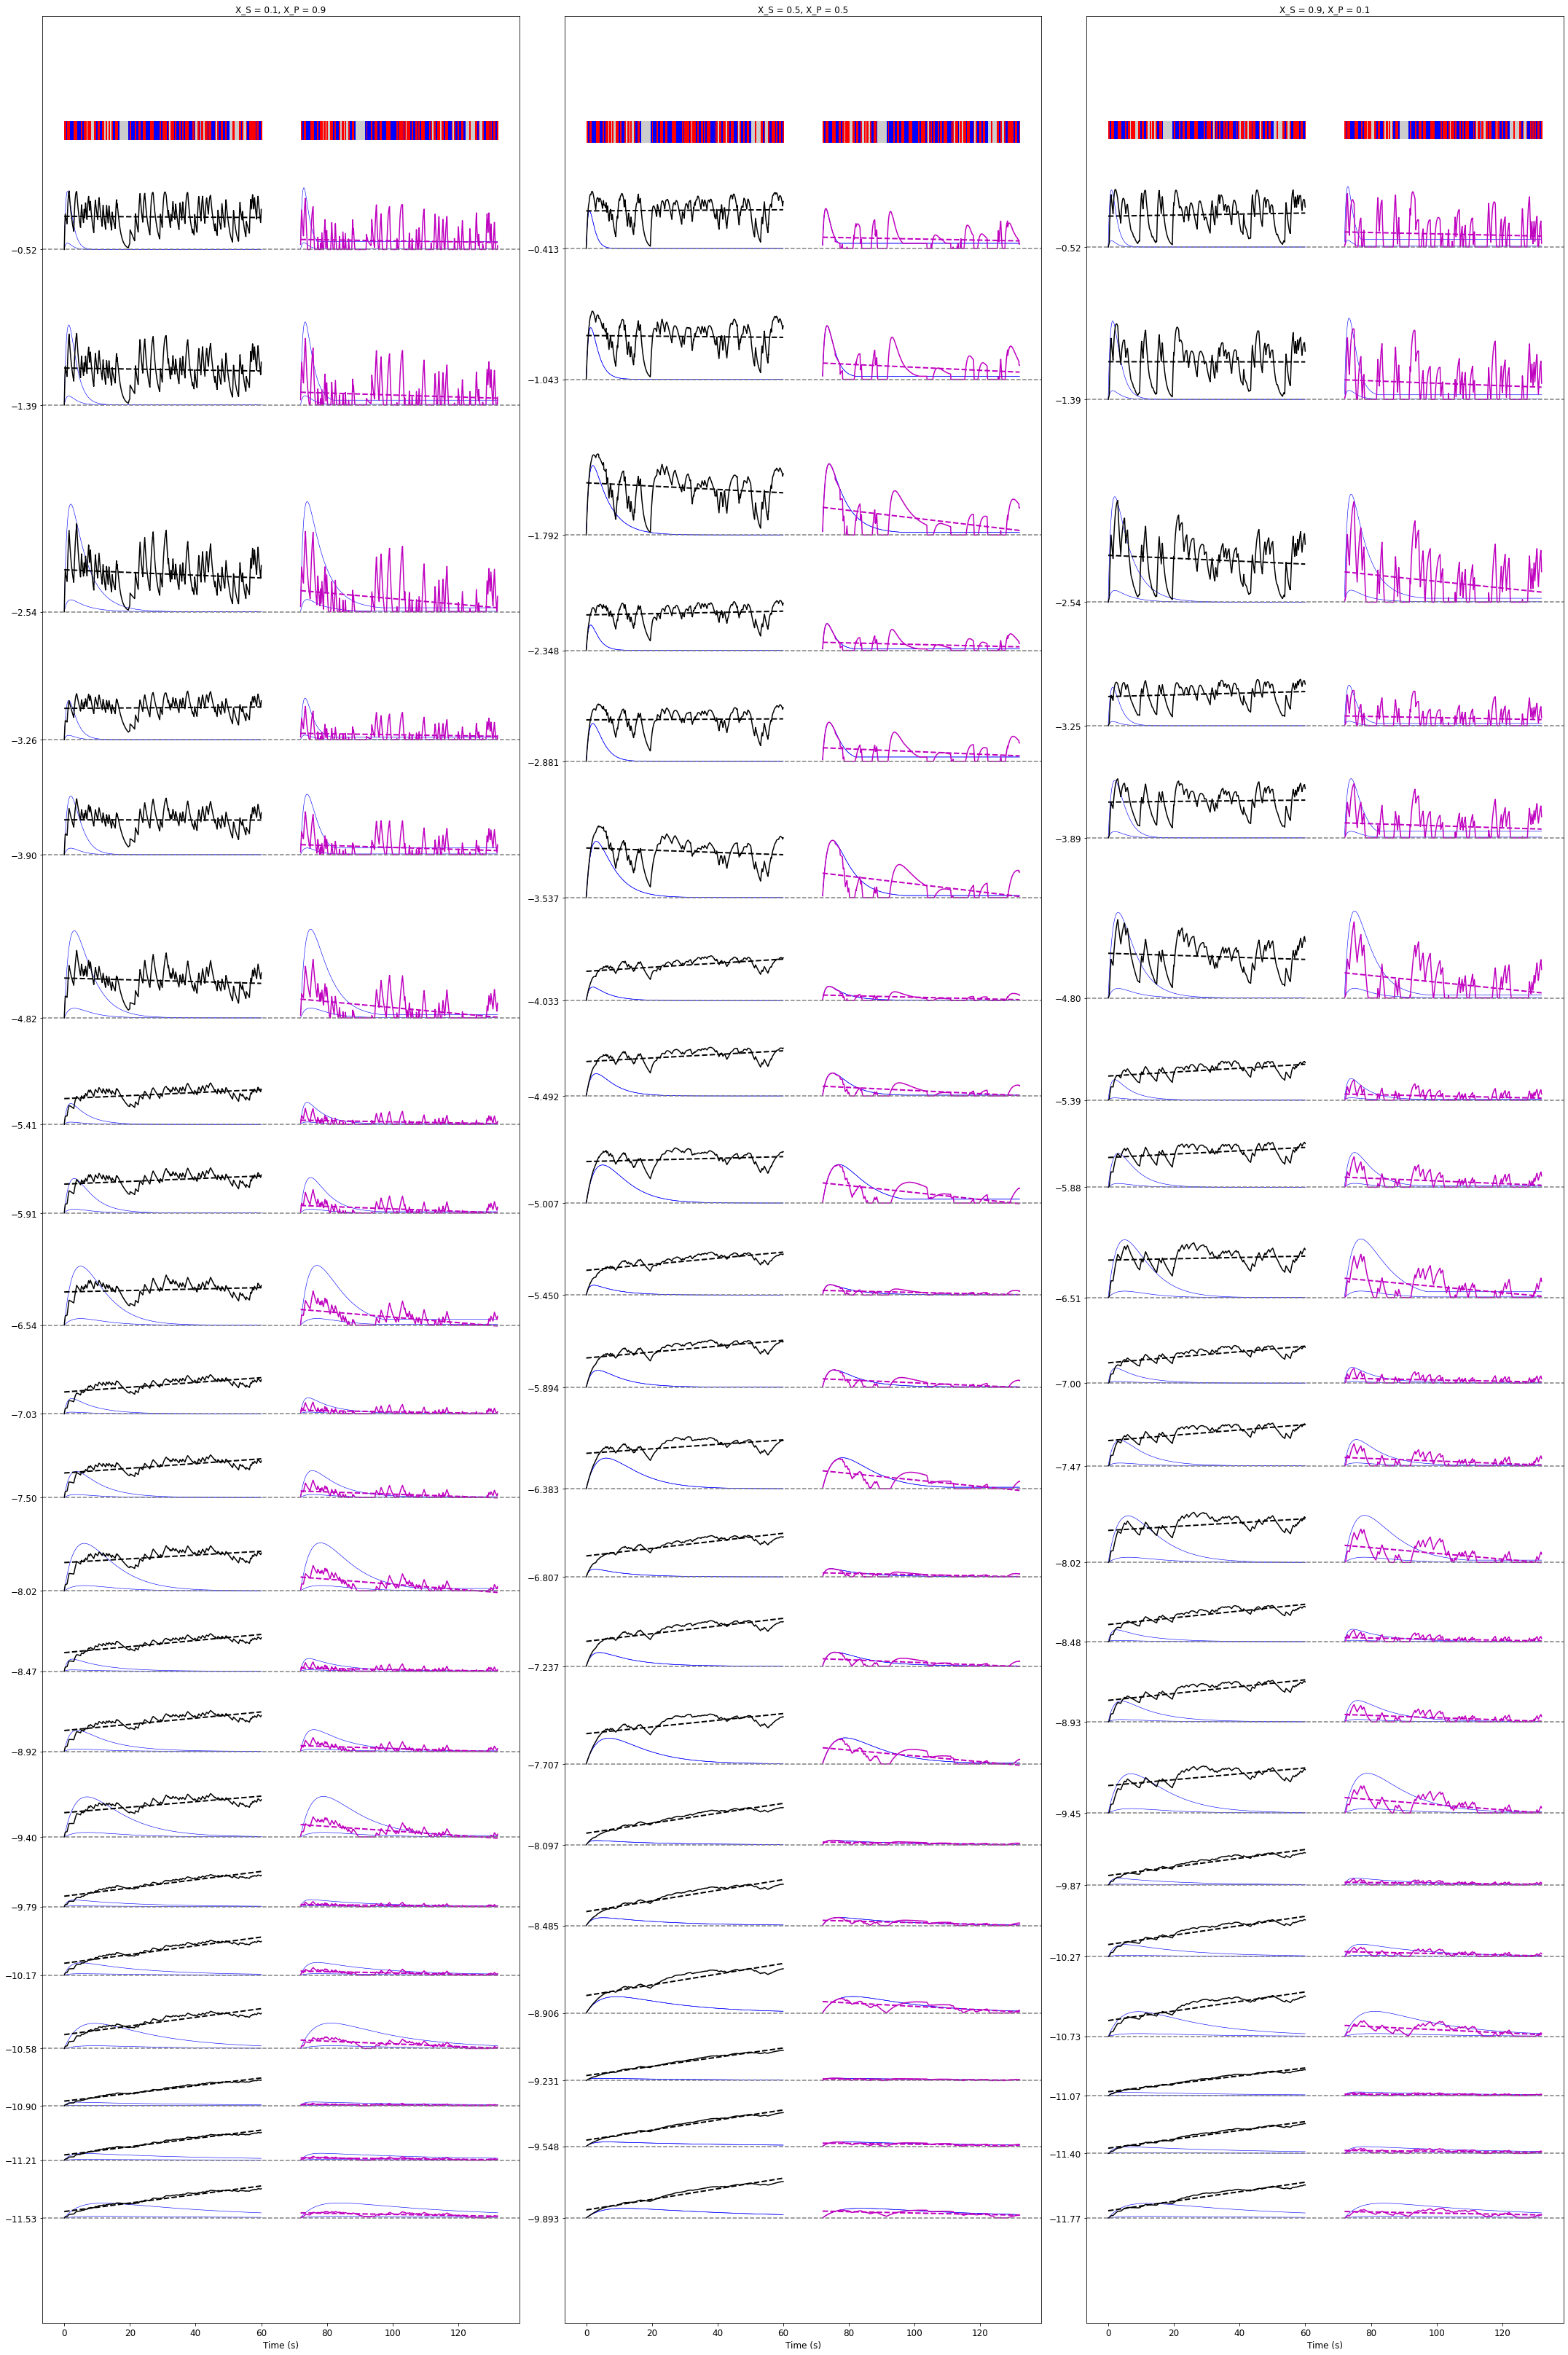

In [11]:
TAU_R = np.array([1, 2, 5, 7.5, 10, 20, 40])
TAU_A = np.array([1, 2, 5])

x_ss = [.1, .5, .9]
# x_ss = [0, .5, 1]

fig, axs = plt.subplots(1, 3, figsize=(30, 45), tight_layout=True)

for ax, x_s in zip(axs, x_ss):
    x_p = 1 - x_s
    
    rs_ma_all = []
    rs_ln_all = []
    ma_taus = list(cprod(TAU_R, TAU_A))
    
    y_offset = 0
    y_ticks = []
    
    plot_b(ax, t, sngs_all[isngs[-1]], c=[(.8, .8, .8), 'b', 'r'], extent=[t[0], t[-1]+DT, 0.1, 0.2])
    plot_b(ax, t, sngs_all[isngs[-1]], c=[(.8, .8, .8), 'b', 'r'], extent=[t[0] + t[-1]*1.2, t[-1]+DT + t[-1]*1.2, 0.1, 0.2])
    
    for tau_r, tau_a in ma_taus:
        
        # get ln filters
        h_s, h_p, th = ma_to_h_ln(tau_r, tau_a, x_s, x_p, DT)

        rs_ma = np.nan*np.zeros((nsng, len(t)))
        rs_ln = np.nan*np.zeros((nsng, len(t)))

        for csng, isng in enumerate(isngs):
            sng = sngs_all[isng]
            i_s = (sng == 1).astype(float)
            i_p = (sng == 2).astype(float)

            r_ma = smlt_ppln_ma(i_s, i_p, np.array([tau_r]), tau_a, x_s, x_p, DT)[:, 0]
            r_ln = smlt_ppln_lnrelu(i_s, i_p, h_s[:, None], h_p[:, None], DT, sign=1)[:, 0]

            rs_ma[csng] = r_ma
            rs_ln[csng] = r_ln
            
        lb = np.nanmin(cc([rs_ma, rs_ln]))
        ub = np.nanmax(cc([rs_ma, rs_ln]))
        
        y_zero = y_offset - 1.5*(ub-lb)
        # plot MA responses
        ax.plot(t, rs_ma[0]+y_zero, c='b', lw=.6)
        ax.plot(t, rs_ma[1]+y_zero, c='b', lw=.6)
        
        for r_ma in rs_ma[2:, :]:
            ax.plot(t, r_ma+y_zero, c='k')
            x_line, y_line = get_line(t, r_ma+y_zero)[:2]
            ax.plot(x_line, y_line, c='k', ls='--', lw=2)
            
        # plot LN responses
        ax.plot(t + t[-1]*1.2, rs_ln[0]+y_zero, c='b', lw=.6)
        ax.plot(t + t[-1]*1.2, rs_ln[1]+y_zero, c='b', lw=.6)
        
        for r_ln in rs_ln[2:, :]:
            ax.plot(t + t[-1]*1.2, r_ln+y_zero, c='m')
            x_line, y_line = get_line(t + t[-1]*1.2, r_ln+y_zero)[:2]
            ax.plot(x_line, y_line, c='m', ls='--', lw=2)
        
        ax.axhline(y_zero, color='gray', ls='--')
        y_ticks.append(y_zero)
        
        y_offset = y_zero - (.5*(ub-lb)) 
        
        rs_ma_all.append(rs_ma)
        rs_ln_all.append(rs_ln)
        
    set_plot(ax, y_ticks=y_ticks, x_label='Time (s)', title=f'X_S = {x_s:.1f}, X_P = {x_p:.1f}', font_size=12)

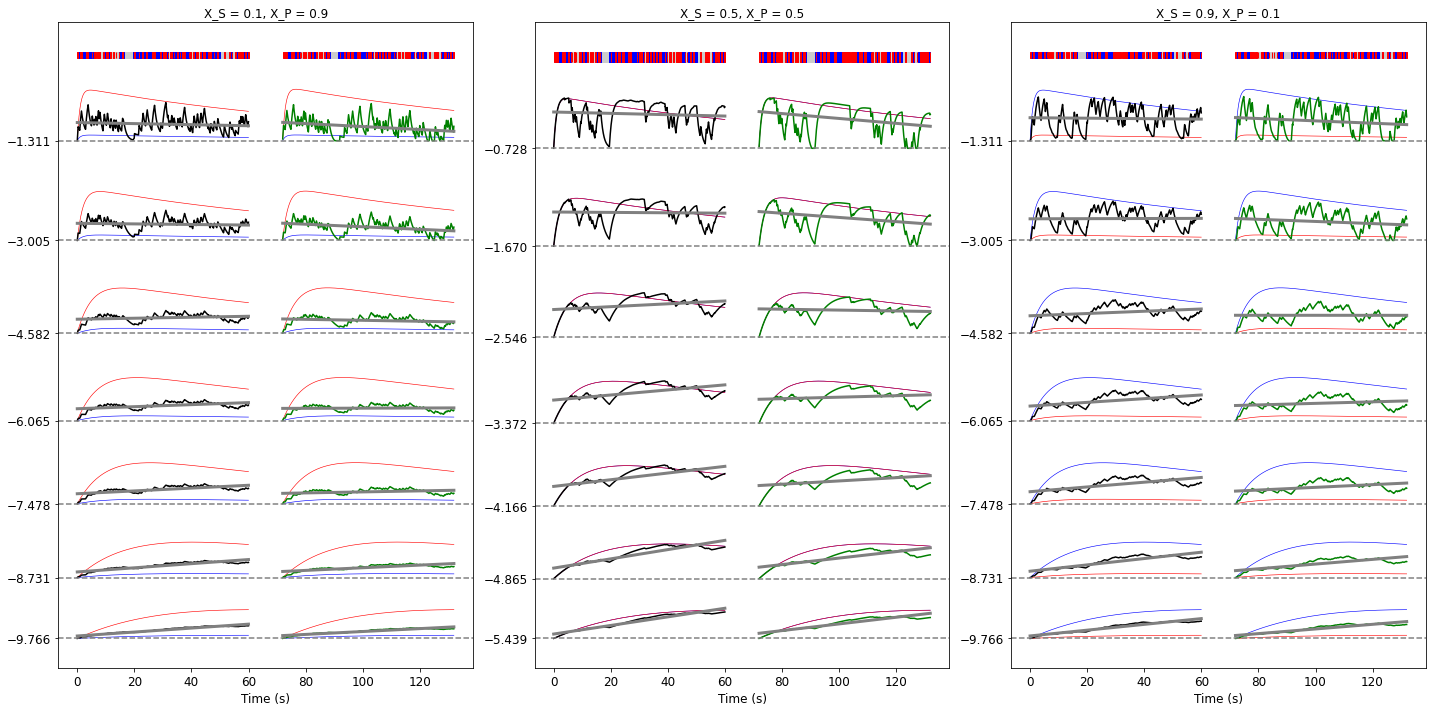

In [10]:
TAU_R = np.array([1, 2, 5, 7.5, 10, 20, 40])
TAU_A = np.array([100])

x_ss = [.1, .5, .9]

fig, axs = plt.subplots(1, 3, figsize=(20, 10), tight_layout=True)

for ax, x_s in zip(axs, x_ss):
    x_p = 1 - x_s
    
    rs_ma_all = []
    rs_ln_all = []
    ma_taus = list(cprod(TAU_R, TAU_A))
    
    y_offset = 0
    y_ticks = []
    
    plot_b(ax, t, sngs_all[isngs[-1]], c=[(.8, .8, .8), 'b', 'r'], extent=[t[0], t[-1]+DT, 0.1, 0.2])
    plot_b(ax, t, sngs_all[isngs[-1]], c=[(.8, .8, .8), 'b', 'r'], extent=[t[0] + t[-1]*1.2, t[-1]+DT + t[-1]*1.2, 0.1, 0.2])
    
    for tau_r, tau_a in ma_taus:
        
        # get ln filters
        h_s, h_p, th = ma_to_h_ln(tau_r, tau_a, x_s, x_p, DT)

        rs_ma = np.nan*np.zeros((nsng, len(t)))
        rs_ln = np.nan*np.zeros((nsng, len(t)))

        for csng, isng in enumerate(isngs):
            sng = sngs_all[isng]
            i_s = (sng == 1).astype(float)
            i_p = (sng == 2).astype(float)

            r_ma = smlt_ppln_ma(i_s, i_p, np.array([tau_r]), tau_a, x_s, x_p, DT)[:, 0]
            r_ln = smlt_ppln_lnrelu(i_s, i_p, h_s[:, None], h_p[:, None], DT, sign=1)[:, 0]

            rs_ma[csng] = r_ma
            rs_ln[csng] = r_ln
            
        lb = np.nanmin(cc([rs_ma, rs_ln]))
        ub = np.nanmax(cc([rs_ma, rs_ln]))
        
        y_zero = y_offset - 1.5*(ub-lb)
        # plot MA responses
        ax.plot(t, rs_ma[0]+y_zero, c='b', lw=.6)
        ax.plot(t, rs_ma[1]+y_zero, c='r', lw=.6)
        
        for r_ma in rs_ma[2:, :]:
            ax.plot(t, r_ma+y_zero, c='k')
            x_line, y_line = get_line(t, r_ma+y_zero)[:2]
            ax.plot(x_line, y_line, c='gray', lw=3)
            
        # plot LN responses
        ax.plot(t + t[-1]*1.2, rs_ln[0]+y_zero, c='b', lw=.6)
        ax.plot(t + t[-1]*1.2, rs_ln[1]+y_zero, c='r', lw=.6)
        
        for r_ln in rs_ln[2:, :]:
            ax.plot(t + t[-1]*1.2, r_ln+y_zero, c='g')
            x_line, y_line = get_line(t + t[-1]*1.2, r_ln+y_zero)[:2]
            ax.plot(x_line, y_line, c='gray', lw=3)
        
        ax.axhline(y_zero, color='gray', ls='--')
        y_ticks.append(y_zero)
        
        y_offset = y_zero - (.5*(ub-lb)) 
        
        rs_ma_all.append(rs_ma)
        rs_ln_all.append(rs_ln)
        
    set_plot(ax, y_ticks=y_ticks, x_label='Time (s)', title=f'X_S = {x_s:.1f}, X_P = {x_p:.1f}', font_size=12)

In [11]:
# save stims
def to_block_repr(sng):
    """Convert vector time-series representation of song to block representation."""
    s = np.array(sng == 1).astype(bool)
    p = np.array(sng == 2).astype(bool)
    q = ~(s | p)
    
    q_segs = get_seg(q, min_gap=1)[1]*DT
    s_segs = get_seg(s, min_gap=1)[1]*DT
    p_segs = get_seg(p, min_gap=1)[1]*DT
    
    if len(q_segs) == 0:
        q_segs = q_segs.reshape((0, 2))
    if len(s_segs) == 0:
        s_segs = s_segs.reshape((0, 2))
    if len(p_segs) == 0:
        p_segs = p_segs.reshape((0, 2))
    
    q_starts = q_segs[:, 0]
    s_starts = s_segs[:, 0]
    p_starts = p_segs[:, 0]
    all_starts = cc([q_starts, s_starts, p_starts])
    
    q_durs = q_segs[:, 1] - q_segs[:, 0]
    s_durs = s_segs[:, 1] - s_segs[:, 0]
    p_durs = p_segs[:, 1] - p_segs[:, 0]
    all_durs = cc([q_durs, s_durs, p_durs])
    
    all_modes = cc([np.repeat('Q', len(q_durs)), np.repeat('S', len(s_durs)), np.repeat('P', len(p_durs))])
    
    idxs_sorted = np.argsort(all_starts)
    
    durs_sorted = all_durs[idxs_sorted]
    modes_sorted = all_modes[idxs_sorted]
    
    return pd.DataFrame(columns=['DURATION', 'MODE'], data={'DURATION': durs_sorted, 'MODE': modes_sorted})

In [15]:
sine_block = sngs_all[isngs[0]]
pulse_block = sngs_all[isngs[1]]
nat_song = sngs_all[isngs[2]]

to_block_repr(sine_block).to_csv(f'data/stimuli_20220812/sine_block_1_min_stim.csv', index=False)
to_block_repr(pulse_block).to_csv(f'data/stimuli_20220812/pulse_block_1_min_stim.csv', index=False)
to_block_repr(nat_song).to_csv(f'data/stimuli_20220812/nat_accum_1_min_stim.csv', index=False)

In [21]:
quiet_1_min = np.zeros(int(round(60/DT)))
sng_concat = cc([sine_block, quiet_1_min, pulse_block, quiet_1_min, nat_song, quiet_1_min])
to_block_repr(sng_concat).to_csv(f'data/stimuli_20220812/sine_quiet_pulse_quiet_nat_quiet.csv', index=False)

In [24]:
sng_df = pd.read_csv('data/stimuli_20220812/sine_quiet_pulse_quiet_nat_quiet.csv')

In [25]:
sng_df

,DURATION,MODE
0,60.006660,S
1,60.006660,Q
2,60.006660,P
3,60.006660,Q
4,0.333000,P
...,...,...
118,0.432900,P
119,0.765901,S
120,0.033300,Q
121,0.166500,P


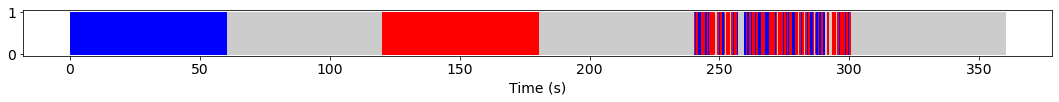

In [34]:
sng_loaded = []

for dur, mode in zip(sng_df['DURATION'], sng_df['MODE']):
    nt = int(round(dur/DT))
    if mode == 'Q':
        sng_loaded.append(np.repeat(0, nt))
    elif mode == 'S':
        sng_loaded.append(np.repeat(1, nt))
    elif mode == 'P':
        sng_loaded.append(np.repeat(2, nt))
        
sng_loaded = cc(sng_loaded)
t_sng_loaded = DT*np.arange(len(sng_loaded))

fig, ax = plt.subplots(1, 1, figsize=(15, 1.5), tight_layout=True)
plot_b(
    ax, t_sng_loaded, sng_loaded, c=[(.8, .8, .8), 'b', 'r'],
    extent=[0, DT*len(sng_loaded), 0, 1])

set_plot(ax, x_label='Time (s)', font_size=14)